January: Part 5 - This notebook is a continuation of gyre_runs_mackenzie03.ipynb. The configuration used to produce these results is still gyre_mackenzie02. 

Recent changes:
* Reorganizing directories and files
* Testing the NEMO Command
* Doubling the previous resolution - 2.24 km

In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

from salishsea_tools import nc_tools, viz_tools

In [3]:
bathyI = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_04.nc')['Bathymetry'][:]
bathyR = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_02.nc')['Bathymetry'][:]

In [4]:
pathI = '/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177/'
pathR = '/ocean/imachuca/Canyons/results_mackenzie/realistic/Resolution_237_177/'
cfg = 'Run01'
gridI1, lonI1, latI1, temI1, salI1, sshI1, UI1, VI1, WI1 = functions_plot.load_model_output(pathI, cfg)
gridR1, lonR1, latR1, temR1, salR1, sshR1, UR1, VR1, WR1 = functions_plot.load_model_output(pathR, cfg)

In [59]:
def plot_quiver_stories(U_vel, V_vel, gridT, depth_inds, time_inds, arrow, bathy):
    fig, ax = plt.subplots(len(time_inds), len(depth_inds), figsize=(18, 30), sharex=True, sharey=True)
    fig.tight_layout()
    for dep, i in zip(depth_inds, np.arange(len(depth_inds))):
        for time_ind, n in zip(time_inds, np.arange(len(time_inds))):
            ugrid = U_vel[time_ind, dep, :, :]
            vgrid = V_vel[time_ind, dep, :, :]
            u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
            v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
            u_nstg = u_nstg0[::arrow,::arrow]
            v_nstg = v_nstg0[::arrow,::arrow]
            x_slice = np.arange(1, ugrid.shape[1])[::arrow]
            y_slice = np.arange(1, ugrid.shape[0])[::arrow]
            speeds = np.sqrt(u_nstg**2 + v_nstg**2)

            q = ax[n, i].quiver(x_slice, y_slice, u_nstg, v_nstg, speeds, clim=[0,0.3],
                          pivot='mid', cmap='Spectral_r', width=0.005, headwidth=2.5)
            ax[n, i].set_ylim(0, y_slice[-1])
            ax[n, i].set_xlim(0, x_slice[-1])
            timestamp = nc_tools.timestamp(gridT,time_ind).format('MMM DD HH:mm')
            ax[n,i].set_yticklabels([])
            dep_m = int(gridI1['deptht'][:][dep])
            if i == 0:
                ax[n, i].set_ylabel(timestamp, fontsize=16)
                fig.colorbar(q, ax=ax[n, i])
            if n == 0:
                ax[n,i].set_title('depth : '+str(dep_m)+' m', fontsize=16)
            ax[n,i].contour(bathy, levels = [dep_m], colors='k', linewidths=2, alpha=0.5)
    return fig

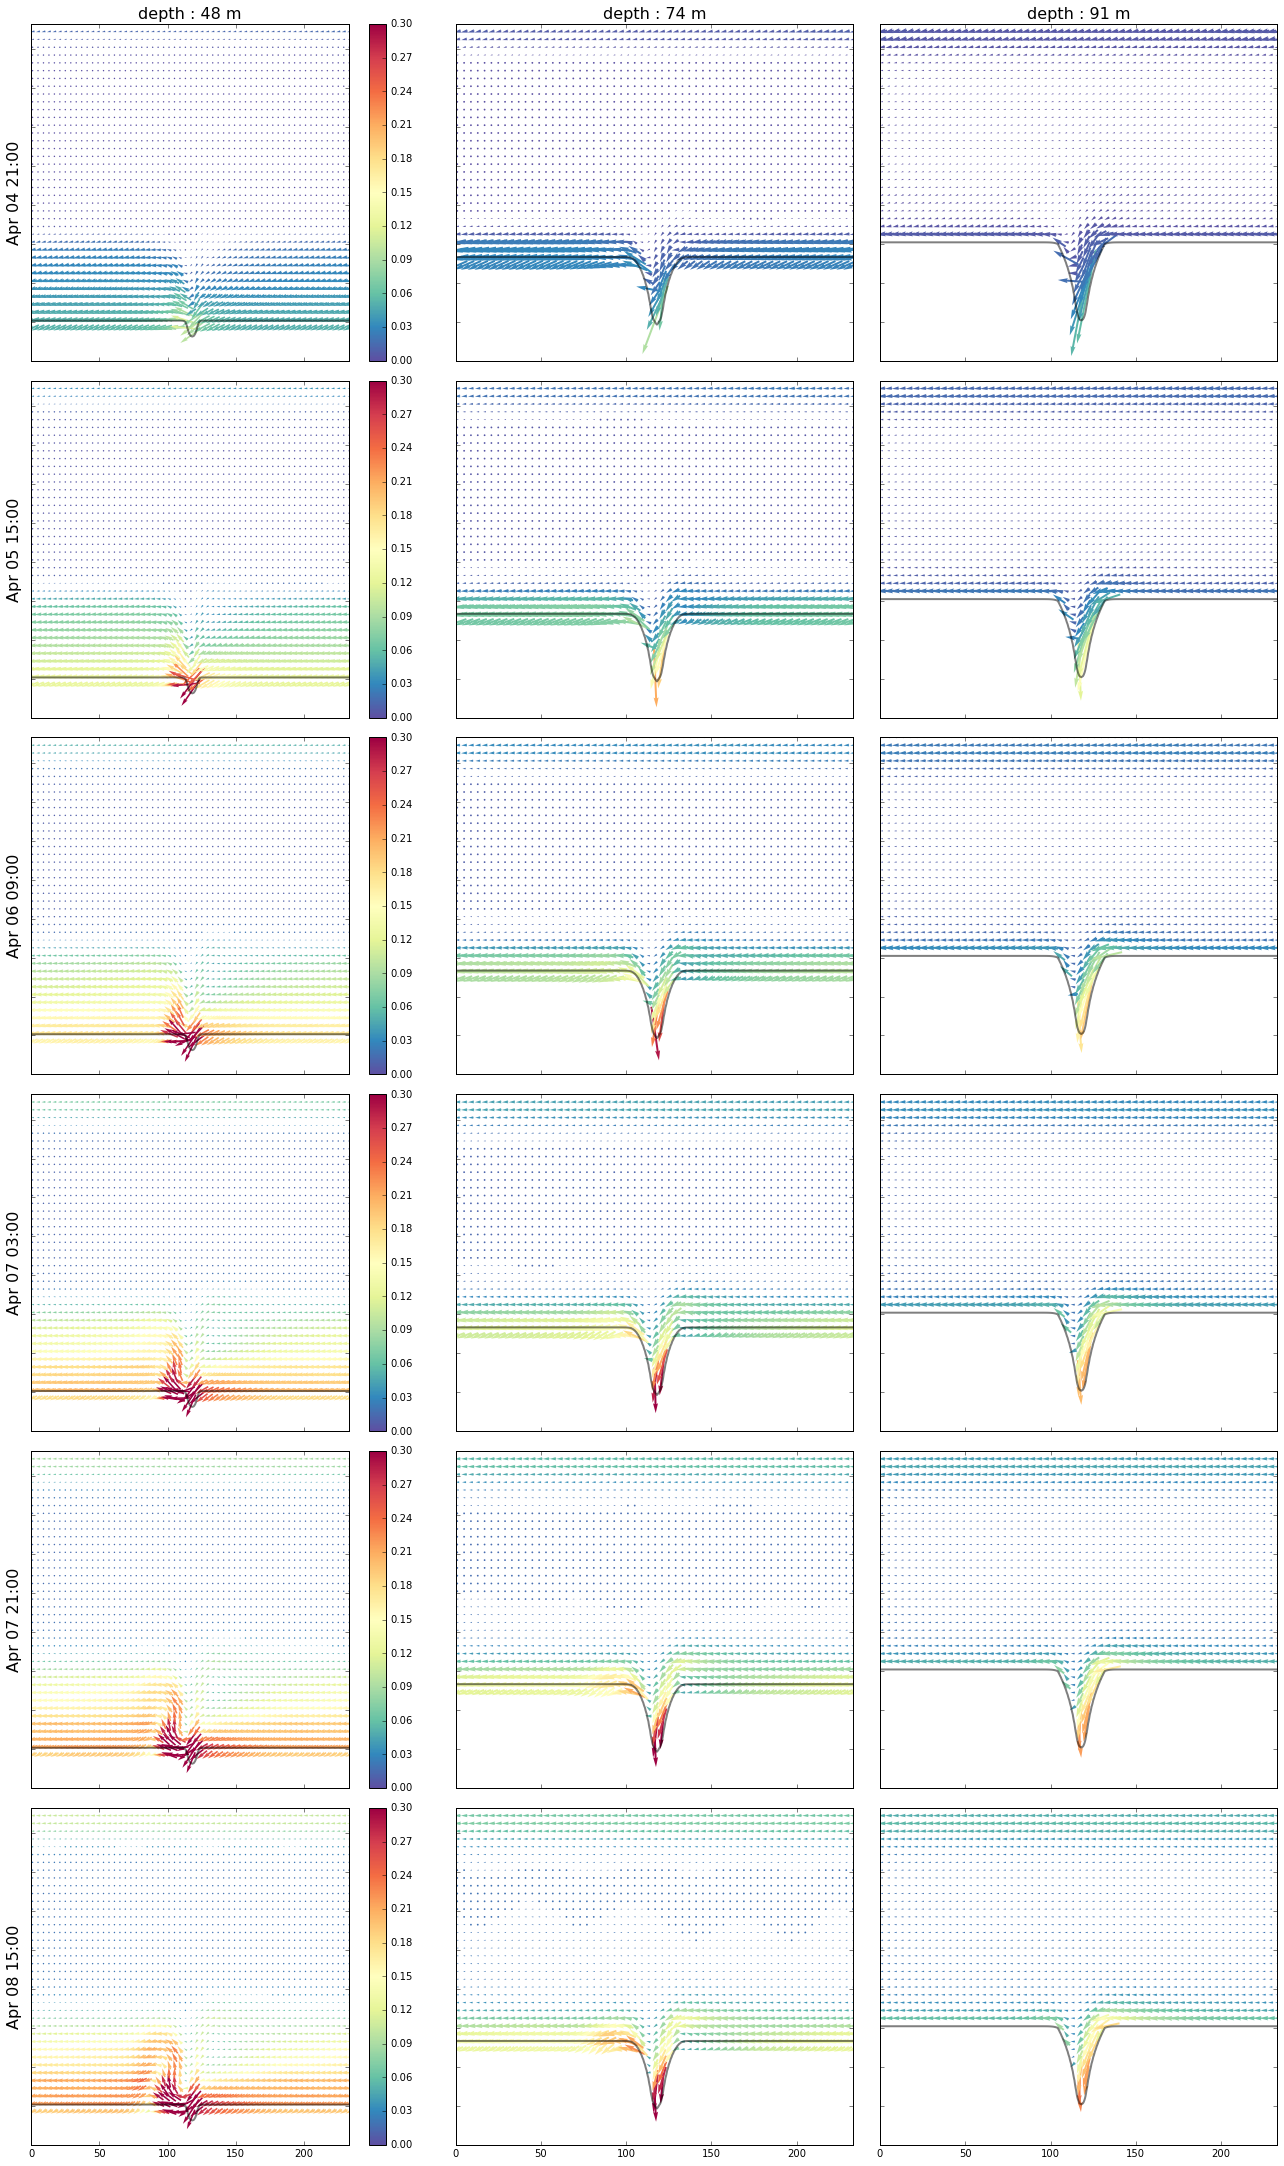

In [60]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UI1, VI1, gridI1, depth_inds, time_inds, 4, bathyI)

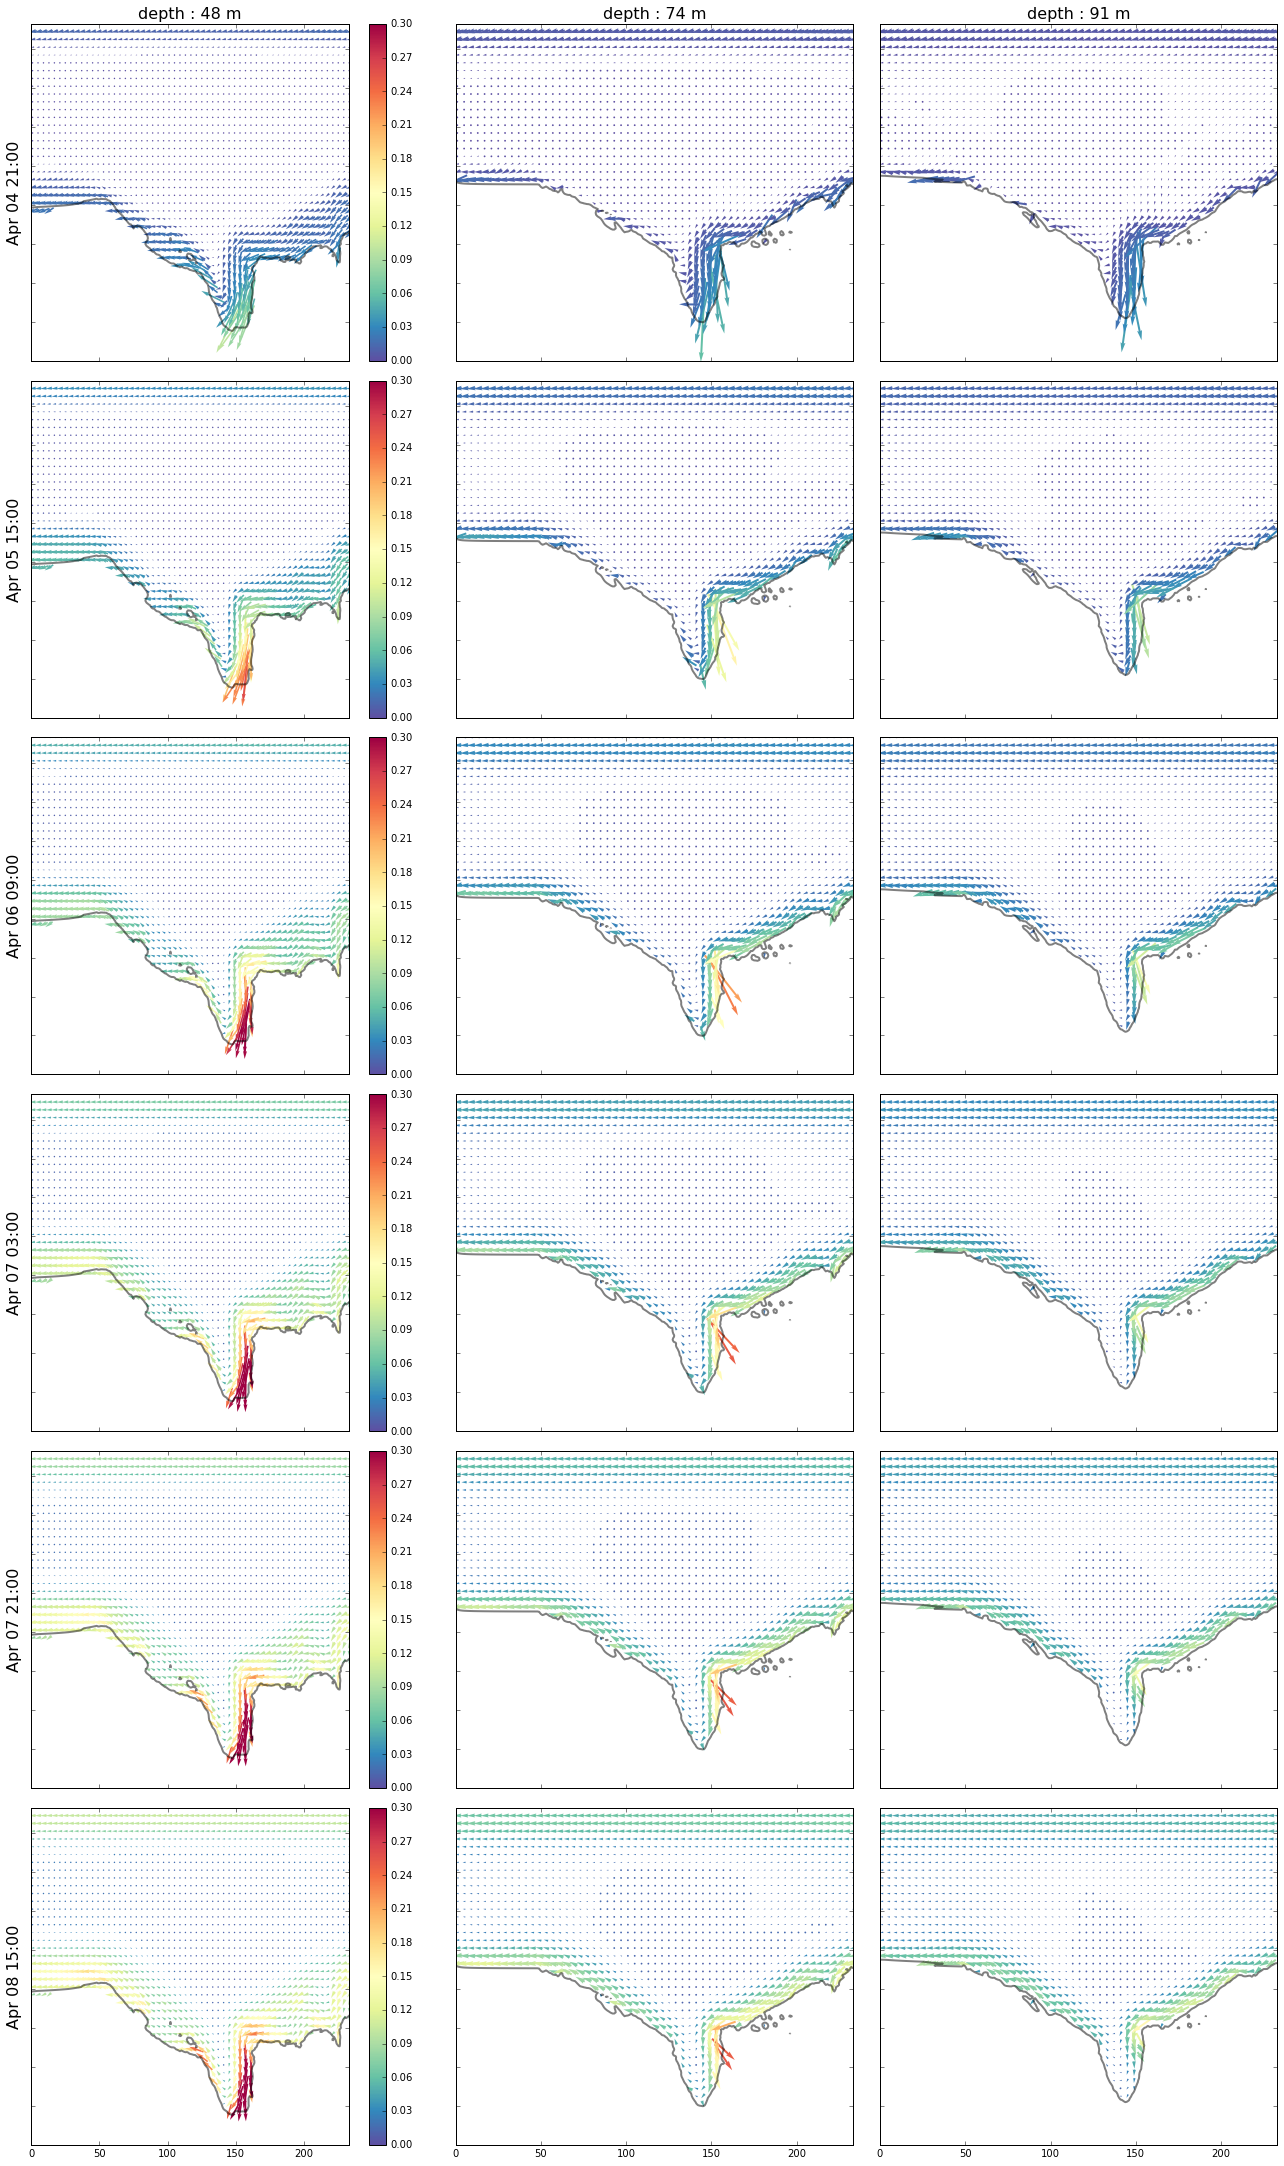

In [61]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UR1, VR1, gridR1, depth_inds, time_inds, 4, bathyR)

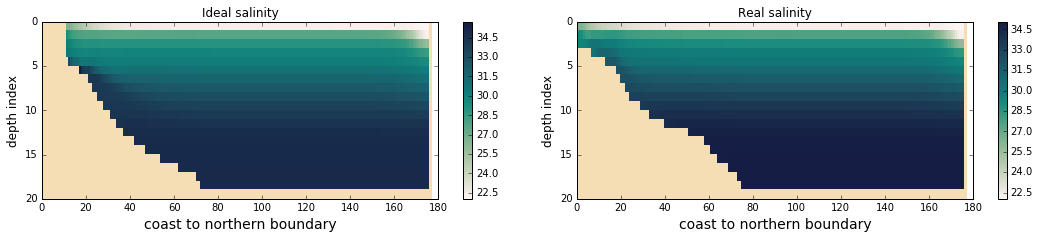

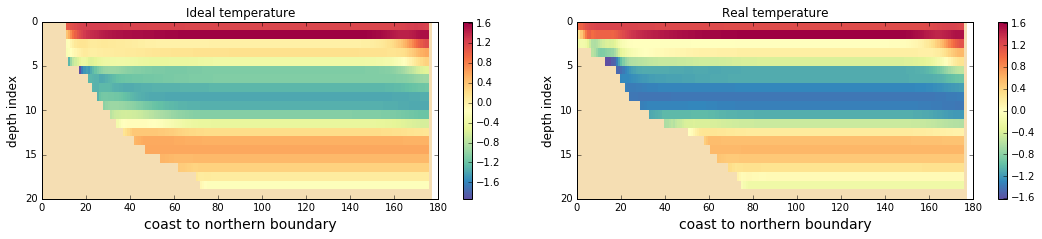

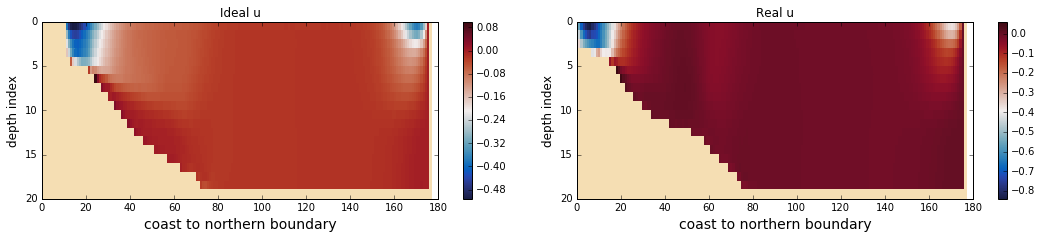

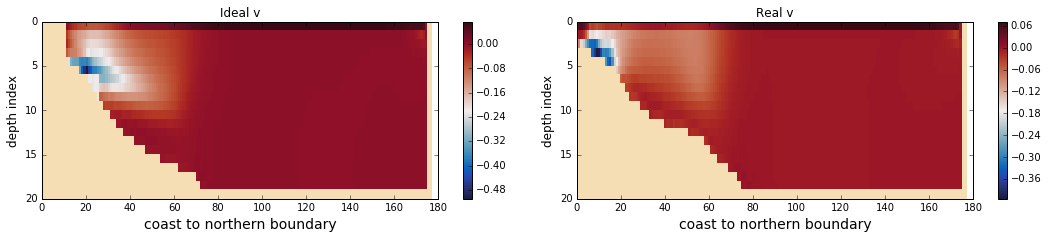

In [40]:
def plot_transect(ttls, variable, cmaps):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 3)); fig.tight_layout()
    cmaps.set_bad('wheat')
    for ax, var, x_point, ttl in zip([ax1, ax2], variable, [120, 145], ttls):
        c = ax.pcolormesh(var[18, :, :, x_point], cmap=cmaps)
        ax.invert_yaxis()
        ax.set_title(ttl, fontsize=12)
        ax.set_xlabel('coast to northern boundary', fontsize=14)
        ax.set_ylabel('depth index', fontsize=12)
        fig.colorbar(c, ax=ax)
    return fig

fig = plot_transect(['Ideal salinity', 'Real salinity'], [salI1, salR1], cmo.cm.tempo)
fig = plot_transect(['Ideal temperature', 'Real temperature'], [temI1, temR1], cm.Spectral_r)
fig = plot_transect(['Ideal u', 'Real u'], [UI1, UR1], cmo.cm.balance)
fig = plot_transect(['Ideal v', 'Real v'], [VI1, VR1], cmo.cm.balance)